# Solving the permuted sequential MNIST (psMNIST) task

The psMNIST (Permuted Sequential MNIST) task is a image classification task introduced
in 2015 by Le, Jaitly, and Hinton ([see paper](https://arxiv.org/pdf/1504.00941.pdf)).
It is based on the Sequential MNIST task, which itself is a derivative of the MNIST
task. Like the MNIST task, the goal of the psMNIST task is to have a neural network
process a 28 x 28 pixel image (of a handwritten digit) into one of ten digits (0 to 9).

However, while the MNIST task presents the entire image to the network all at once, the
Sequential MNIST and psMNIST tasks turn the image into a stream of 784 (28x28)
individual pixels, presented to the network one at a time. The goal of the network is
then to classify the pixel sequence as the appropriate digit after the last pixel has
been shown. The psMNIST task adds more complexity to the input by applying a fixed
permutation to all of the pixel sequences. This is done to ensure that the information
contained in the image is distributed evenly throughout the sequence, so that in order
to perform the task successfully the network needs to process information across the
whole length of the input sequence.

The following notebook uses a single KerasLMU layer inside a simple TensorFlow model to
showcase the accuracy and efficiency of performing the psMNIST task using these novel
memory cells. Using the LMU for this task currently produces state-of-the-art results
([see
paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf)).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

import keras_lmu

2023-05-05 19:33:05.780912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and formatting the dataset

First we set a seed to ensure that the results in this example are reproducible. A
random number generator (`rng`) is also created, and this will later be used to
generate the fixed permutation to be applied to the image data.

In [2]:
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

We now obtain the standard MNIST dataset of handwritten digits from `tf.keras.datasets`.

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

Since the pixel values of each image in the dataset have a range of 0 to 255, they are
divided by 255 to change this range to 0 to 1. Let's also display a sample image from
the MNIST dataset to get an idea of the kind of images the network is working with.

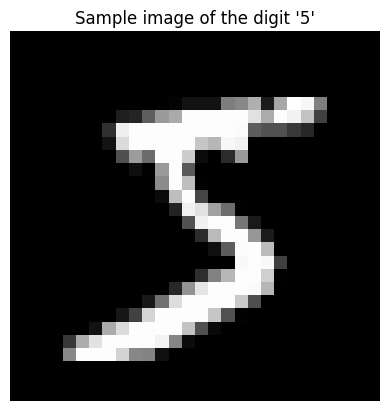

In [4]:
train_images = train_images / 255
test_images = test_images / 255

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title(f"Sample image of the digit '{train_labels[0]}'")
plt.show()

Next, we have to convert the data from the MNIST format into the sequence of pixels that
is used in the psMNIST task. To do this, we flatten the image by calling the `reshape`
method on the images. The first dimension of the reshaped output size represents the
number of samples our dataset has, which we keep the same. We want to transform each
sample into a column vector, and to do so we make the second and third dimensions -1 and
1, respectively.

The image displayed below shows the result of this flattening process, and is an example
of the type of data that is used in the Sequential MNIST task. Note that even though the
image has been flattened, there is still a fair amount of structure observable in the
image.

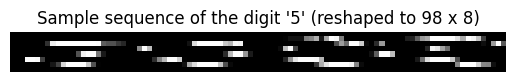

In [5]:
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Sample sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

Finally, we apply a fixed permutation on the images in both the training and testing
datasets. This shuffles the pixels of the image sequences in a consistent
way, allowing for images of the same digit to still be similar, but removing the
convenience of edges and contours that the network can use for easy digit inference.

We can see, from the image below, that the fixed permutation applied to the image
creates an even distribute of pixels across the entire sequence. This makes the task
much more difficult, as it makes it necessary for the network to process the entire
input
sequence to accurately classify the digit. We now have our data for the Permuted
Sequential MNIST (psMNIST) task.

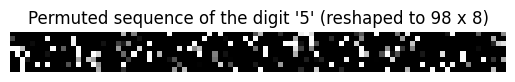

In [6]:
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(f"Permuted sequence of the digit '{train_labels[0]}' (reshaped to 98 x 8)")
plt.show()

From the images in the training set, we allocate the first 50,000 images for training,
and the remaining 10,000 for validation. We print out the shapes of these datasets to
ensure the slicing has been done correctly.

In [7]:
X_train = train_images[:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(
    f"Training inputs shape: {X_train.shape}, "
    f"Training targets shape: {Y_train.shape}"
)
print(
    f"Validation inputs shape: {X_valid.shape}, "
    f"Validation targets shape: {Y_valid.shape}"
)
print(f"Testing inputs shape: {X_test.shape}, Testing targets shape: {Y_test.shape}")

Training inputs shape: (50000, 784, 1), Training targets shape: (50000,)
Validation inputs shape: (10000, 784, 1), Validation targets shape: (10000,)
Testing inputs shape: (10000, 784, 1), Testing targets shape: (10000,)


## Defining the model

Our model uses a single LMU layer configured with 212 hidden `units` and an `order` of
256
dimensions for the memory, maintaining `units` + `order` = 468 variables in memory
between time-steps. These numbers were chosen primarily to have a comparable number of
internal variables to the models that were being compared against in the
[paper](https://arxiv.org/pdf/1504.00941.pdf).
We set `theta` to 784 (the number of pixels in each sequence). We also disable the
`hidden_to_memory` and `memory_to_memory` connections, as based on our experimentation
they are not needed/helpful in this problem.

The output of the LMU layer is connected to a `Dense` linear layer with an output
dimensionality of 10, one for each possible digit class.

In [8]:
n_pixels = X_train.shape[1]

lmu_layer = keras_lmu.LMU(
    memory_d=1,
    order=256,
    theta=n_pixels,
    hidden_cell=tf.keras.layers.SimpleRNNCell(212),
    hidden_to_memory=False,
    memory_to_memory=False,
    input_to_hidden=True,
    kernel_initializer="ones",
)

# TensorFlow layer definition
inputs = tf.keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(10)(lmus)

# TensorFlow model definition
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model.summary()

2023-05-05 19:33:18.186509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 19:33:18.694519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10810 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


2023-05-05 19:33:29.283110: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x560ad72a69e0


Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 784, 1)]          0         


 lmu (LMU)                   (None, 212)               99641     


 dense (Dense)               (None, 10)                2130      


Total params: 101,771


Trainable params: 101,771


Non-trainable params: 0


_________________________________________________________________


## Training the model

To train our model we use a `batch_size` of 100 and train for 10 `epochs`, which is
far less than most other solutions to the psMNIST task. We could train for more epochs
if we wished to fine-tune performance, but that is not necessary for the purposes of
this example. We also create a `ModelCheckpoint` callback that saves the weights of the
model to a file after each epoch.

Training may take
a long time to complete, and to save time this notebook defaults to using pre-trained
weights. To train the model from scratch, simply change the `do_training` variable to
`True` before running the cell below.

In [9]:
do_training = False
batch_size = 100
epochs = 10

saved_weights_fname = "./psMNIST-weights.hdf5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_weights_fname, monitor="val_loss", verbose=1, save_best_only=True
    ),
]

result = None
if do_training:
    result = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, Y_valid),
        callbacks=callbacks,
    )

The progression of the training process is shown below, plotting the
training and validation accuracy.

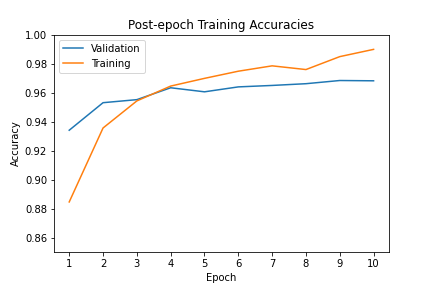

In [10]:
if do_training:
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Post-epoch training accuracies")
    plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
    plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
    plt.savefig("psMNIST-training.png")

    val_loss_min = np.argmin(result.history["val_loss"])
    print(
        f"Maximum validation accuracy: "
        f"{round(result.history['val_accuracy'][val_loss_min] * 100, 2):.2f}%"
    )

else:
    display(Image(filename="psMNIST-training.png"))

## Testing the model

With the training complete, let's use the trained weights to test the model. Since the
best weights are saved to file, we can simply load the saved weights, then
test it against the permuted sequences in the test set.

In [11]:
model.load_weights(saved_weights_fname)
accuracy = model.evaluate(X_test, Y_test)[1] * 100
print(f"Test accuracy: {round(accuracy, 2):0.2f}%")

  1/313 [..............................] - ETA: 3:02 - loss: 0.0459 - accuracy: 0.9688

  2/313 [..............................] - ETA: 33s - loss: 0.0539 - accuracy: 0.9688 

  3/313 [..............................] - ETA: 32s - loss: 0.0442 - accuracy: 0.9792

  4/313 [..............................] - ETA: 31s - loss: 0.0424 - accuracy: 0.9766

  5/313 [..............................] - ETA: 30s - loss: 0.0499 - accuracy: 0.9688

  6/313 [..............................] - ETA: 29s - loss: 0.0434 - accuracy: 0.9740

  7/313 [..............................] - ETA: 28s - loss: 0.0406 - accuracy: 0.9777

  8/313 [..............................] - ETA: 28s - loss: 0.0637 - accuracy: 0.9727

  9/313 [..............................] - ETA: 27s - loss: 0.0690 - accuracy: 0.9722

 10/313 [..............................] - ETA: 27s - loss: 0.0708 - accuracy: 0.9719

 11/313 [>.............................] - ETA: 26s - loss: 0.0802 - accuracy: 0.9716

 12/313 [>.............................] - ETA: 26s - loss: 0.0888 - accuracy: 0.9714

 13/313 [>.............................] - ETA: 25s - loss: 0.0847 - accuracy: 0.9736

 14/313 [>.............................] - ETA: 25s - loss: 0.0923 - accuracy: 0.9688

 15/313 [>.............................] - ETA: 25s - loss: 0.0920 - accuracy: 0.9688

 16/313 [>.............................] - ETA: 24s - loss: 0.0900 - accuracy: 0.9688

 17/313 [>.............................] - ETA: 24s - loss: 0.0861 - accuracy: 0.9706

 18/313 [>.............................] - ETA: 24s - loss: 0.0827 - accuracy: 0.9722

 19/313 [>.............................] - ETA: 24s - loss: 0.0844 - accuracy: 0.9704

 20/313 [>.............................] - ETA: 23s - loss: 0.0907 - accuracy: 0.9688

 21/313 [=>............................] - ETA: 23s - loss: 0.0914 - accuracy: 0.9688

 22/313 [=>............................] - ETA: 23s - loss: 0.0929 - accuracy: 0.9688

 23/313 [=>............................] - ETA: 23s - loss: 0.1024 - accuracy: 0.9674

 24/313 [=>............................] - ETA: 23s - loss: 0.1004 - accuracy: 0.9674

 25/313 [=>............................] - ETA: 23s - loss: 0.0995 - accuracy: 0.9675

 26/313 [=>............................] - ETA: 22s - loss: 0.0967 - accuracy: 0.9688

 27/313 [=>............................] - ETA: 22s - loss: 0.0942 - accuracy: 0.9688

 28/313 [=>............................] - ETA: 22s - loss: 0.0921 - accuracy: 0.9699

 29/313 [=>............................] - ETA: 22s - loss: 0.0959 - accuracy: 0.9698

 30/313 [=>............................] - ETA: 22s - loss: 0.1055 - accuracy: 0.9646

 31/313 [=>............................] - ETA: 22s - loss: 0.1051 - accuracy: 0.9647

 32/313 [==>...........................] - ETA: 22s - loss: 0.1165 - accuracy: 0.9639

 33/313 [==>...........................] - ETA: 22s - loss: 0.1165 - accuracy: 0.9631

 34/313 [==>...........................] - ETA: 22s - loss: 0.1156 - accuracy: 0.9632

 35/313 [==>...........................] - ETA: 21s - loss: 0.1180 - accuracy: 0.9625

 36/313 [==>...........................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9627

 37/313 [==>...........................] - ETA: 21s - loss: 0.1168 - accuracy: 0.9620

 38/313 [==>...........................] - ETA: 21s - loss: 0.1163 - accuracy: 0.9622

 39/313 [==>...........................] - ETA: 21s - loss: 0.1319 - accuracy: 0.9607

 40/313 [==>...........................] - ETA: 21s - loss: 0.1330 - accuracy: 0.9609

 41/313 [==>...........................] - ETA: 21s - loss: 0.1342 - accuracy: 0.9604

 42/313 [===>..........................] - ETA: 21s - loss: 0.1377 - accuracy: 0.9598

 43/313 [===>..........................] - ETA: 21s - loss: 0.1348 - accuracy: 0.9608

 44/313 [===>..........................] - ETA: 20s - loss: 0.1394 - accuracy: 0.9602

 45/313 [===>..........................] - ETA: 20s - loss: 0.1390 - accuracy: 0.9597

 46/313 [===>..........................] - ETA: 20s - loss: 0.1393 - accuracy: 0.9592

 47/313 [===>..........................] - ETA: 20s - loss: 0.1398 - accuracy: 0.9594

 48/313 [===>..........................] - ETA: 20s - loss: 0.1407 - accuracy: 0.9590

 49/313 [===>..........................] - ETA: 20s - loss: 0.1413 - accuracy: 0.9592

 50/313 [===>..........................] - ETA: 20s - loss: 0.1395 - accuracy: 0.9594

 51/313 [===>..........................] - ETA: 20s - loss: 0.1406 - accuracy: 0.9589

 52/313 [===>..........................] - ETA: 20s - loss: 0.1416 - accuracy: 0.9579

 53/313 [====>.........................] - ETA: 20s - loss: 0.1470 - accuracy: 0.9570

 54/313 [====>.........................] - ETA: 20s - loss: 0.1493 - accuracy: 0.9566

 55/313 [====>.........................] - ETA: 19s - loss: 0.1552 - accuracy: 0.9551

 56/313 [====>.........................] - ETA: 19s - loss: 0.1564 - accuracy: 0.9554

 57/313 [====>.........................] - ETA: 19s - loss: 0.1541 - accuracy: 0.9561

 58/313 [====>.........................] - ETA: 19s - loss: 0.1529 - accuracy: 0.9564

 59/313 [====>.........................] - ETA: 19s - loss: 0.1524 - accuracy: 0.9566

 60/313 [====>.........................] - ETA: 19s - loss: 0.1551 - accuracy: 0.9568

 61/313 [====>.........................] - ETA: 19s - loss: 0.1543 - accuracy: 0.9570

 62/313 [====>.........................] - ETA: 19s - loss: 0.1533 - accuracy: 0.9572

 63/313 [=====>........................] - ETA: 19s - loss: 0.1555 - accuracy: 0.9568

 64/313 [=====>........................] - ETA: 19s - loss: 0.1596 - accuracy: 0.9556

 65/313 [=====>........................] - ETA: 19s - loss: 0.1619 - accuracy: 0.9543

 66/313 [=====>........................] - ETA: 18s - loss: 0.1655 - accuracy: 0.9541

 67/313 [=====>........................] - ETA: 18s - loss: 0.1702 - accuracy: 0.9534

 68/313 [=====>........................] - ETA: 18s - loss: 0.1682 - accuracy: 0.9540

 69/313 [=====>........................] - ETA: 18s - loss: 0.1668 - accuracy: 0.9543

 70/313 [=====>........................] - ETA: 18s - loss: 0.1652 - accuracy: 0.9549

 71/313 [=====>........................] - ETA: 18s - loss: 0.1632 - accuracy: 0.9555

 72/313 [=====>........................] - ETA: 18s - loss: 0.1699 - accuracy: 0.9544

 73/313 [=====>........................] - ETA: 18s - loss: 0.1705 - accuracy: 0.9542

 74/313 [======>.......................] - ETA: 18s - loss: 0.1685 - accuracy: 0.9548

 75/313 [======>.......................] - ETA: 18s - loss: 0.1700 - accuracy: 0.9542

 76/313 [======>.......................] - ETA: 18s - loss: 0.1743 - accuracy: 0.9531

 77/313 [======>.......................] - ETA: 18s - loss: 0.1732 - accuracy: 0.9533

 78/313 [======>.......................] - ETA: 17s - loss: 0.1729 - accuracy: 0.9535

 79/313 [======>.......................] - ETA: 17s - loss: 0.1710 - accuracy: 0.9541

 80/313 [======>.......................] - ETA: 17s - loss: 0.1712 - accuracy: 0.9539

 81/313 [======>.......................] - ETA: 17s - loss: 0.1694 - accuracy: 0.9545

 82/313 [======>.......................] - ETA: 17s - loss: 0.1681 - accuracy: 0.9546

 83/313 [======>.......................] - ETA: 17s - loss: 0.1712 - accuracy: 0.9537

 84/313 [=======>......................] - ETA: 17s - loss: 0.1696 - accuracy: 0.9542

 85/313 [=======>......................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9544

 86/313 [=======>......................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9542

 87/313 [=======>......................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9544

 88/313 [=======>......................] - ETA: 17s - loss: 0.1651 - accuracy: 0.9549

 89/313 [=======>......................] - ETA: 17s - loss: 0.1640 - accuracy: 0.9551

 90/313 [=======>......................] - ETA: 17s - loss: 0.1630 - accuracy: 0.9552

 91/313 [=======>......................] - ETA: 16s - loss: 0.1627 - accuracy: 0.9554

 92/313 [=======>......................] - ETA: 16s - loss: 0.1656 - accuracy: 0.9538

 93/313 [=======>......................] - ETA: 16s - loss: 0.1643 - accuracy: 0.9543

 94/313 [========>.....................] - ETA: 16s - loss: 0.1652 - accuracy: 0.9541

 95/313 [========>.....................] - ETA: 16s - loss: 0.1636 - accuracy: 0.9546

 96/313 [========>.....................] - ETA: 16s - loss: 0.1628 - accuracy: 0.9548

 97/313 [========>.....................] - ETA: 16s - loss: 0.1626 - accuracy: 0.9549

 98/313 [========>.....................] - ETA: 16s - loss: 0.1630 - accuracy: 0.9547

 99/313 [========>.....................] - ETA: 16s - loss: 0.1625 - accuracy: 0.9549

100/313 [========>.....................] - ETA: 16s - loss: 0.1620 - accuracy: 0.9547

101/313 [========>.....................] - ETA: 16s - loss: 0.1617 - accuracy: 0.9545

102/313 [========>.....................] - ETA: 16s - loss: 0.1607 - accuracy: 0.9547

103/313 [========>.....................] - ETA: 15s - loss: 0.1603 - accuracy: 0.9545

104/313 [========>.....................] - ETA: 15s - loss: 0.1589 - accuracy: 0.9549

105/313 [=========>....................] - ETA: 15s - loss: 0.1583 - accuracy: 0.9551

106/313 [=========>....................] - ETA: 15s - loss: 0.1578 - accuracy: 0.9549

107/313 [=========>....................] - ETA: 15s - loss: 0.1571 - accuracy: 0.9550

108/313 [=========>....................] - ETA: 15s - loss: 0.1567 - accuracy: 0.9552

109/313 [=========>....................] - ETA: 15s - loss: 0.1564 - accuracy: 0.9553

110/313 [=========>....................] - ETA: 15s - loss: 0.1564 - accuracy: 0.9554

111/313 [=========>....................] - ETA: 15s - loss: 0.1587 - accuracy: 0.9552

112/313 [=========>....................] - ETA: 15s - loss: 0.1581 - accuracy: 0.9554

113/313 [=========>....................] - ETA: 15s - loss: 0.1583 - accuracy: 0.9552

114/313 [=========>....................] - ETA: 15s - loss: 0.1569 - accuracy: 0.9556

115/313 [==========>...................] - ETA: 15s - loss: 0.1571 - accuracy: 0.9557

116/313 [==========>...................] - ETA: 14s - loss: 0.1561 - accuracy: 0.9561

117/313 [==========>...................] - ETA: 14s - loss: 0.1550 - accuracy: 0.9565

118/313 [==========>...................] - ETA: 14s - loss: 0.1554 - accuracy: 0.9558

119/313 [==========>...................] - ETA: 14s - loss: 0.1582 - accuracy: 0.9551

120/313 [==========>...................] - ETA: 14s - loss: 0.1599 - accuracy: 0.9547

121/313 [==========>...................] - ETA: 14s - loss: 0.1603 - accuracy: 0.9545

122/313 [==========>...................] - ETA: 14s - loss: 0.1596 - accuracy: 0.9544

123/313 [==========>...................] - ETA: 14s - loss: 0.1594 - accuracy: 0.9543

124/313 [==========>...................] - ETA: 14s - loss: 0.1615 - accuracy: 0.9539

125/313 [==========>...................] - ETA: 14s - loss: 0.1609 - accuracy: 0.9540

126/313 [===========>..................] - ETA: 14s - loss: 0.1604 - accuracy: 0.9541

127/313 [===========>..................] - ETA: 14s - loss: 0.1594 - accuracy: 0.9545

128/313 [===========>..................] - ETA: 14s - loss: 0.1601 - accuracy: 0.9541

129/313 [===========>..................] - ETA: 13s - loss: 0.1594 - accuracy: 0.9542

130/313 [===========>..................] - ETA: 13s - loss: 0.1584 - accuracy: 0.9546

131/313 [===========>..................] - ETA: 13s - loss: 0.1595 - accuracy: 0.9544

132/313 [===========>..................] - ETA: 13s - loss: 0.1600 - accuracy: 0.9543

133/313 [===========>..................] - ETA: 13s - loss: 0.1604 - accuracy: 0.9542

134/313 [===========>..................] - ETA: 13s - loss: 0.1603 - accuracy: 0.9541

135/313 [===========>..................] - ETA: 13s - loss: 0.1627 - accuracy: 0.9537

136/313 [============>.................] - ETA: 13s - loss: 0.1620 - accuracy: 0.9538

137/313 [============>.................] - ETA: 13s - loss: 0.1619 - accuracy: 0.9537

138/313 [============>.................] - ETA: 13s - loss: 0.1608 - accuracy: 0.9540

139/313 [============>.................] - ETA: 13s - loss: 0.1615 - accuracy: 0.9532

140/313 [============>.................] - ETA: 13s - loss: 0.1609 - accuracy: 0.9533

141/313 [============>.................] - ETA: 13s - loss: 0.1626 - accuracy: 0.9528

142/313 [============>.................] - ETA: 12s - loss: 0.1619 - accuracy: 0.9529

143/313 [============>.................] - ETA: 12s - loss: 0.1616 - accuracy: 0.9528

144/313 [============>.................] - ETA: 12s - loss: 0.1618 - accuracy: 0.9529

145/313 [============>.................] - ETA: 12s - loss: 0.1615 - accuracy: 0.9530

146/313 [============>.................] - ETA: 12s - loss: 0.1606 - accuracy: 0.9533

147/313 [=============>................] - ETA: 12s - loss: 0.1602 - accuracy: 0.9534

148/313 [=============>................] - ETA: 12s - loss: 0.1597 - accuracy: 0.9535

149/313 [=============>................] - ETA: 12s - loss: 0.1606 - accuracy: 0.9530

150/313 [=============>................] - ETA: 12s - loss: 0.1595 - accuracy: 0.9533

151/313 [=============>................] - ETA: 12s - loss: 0.1616 - accuracy: 0.9528

152/313 [=============>................] - ETA: 12s - loss: 0.1607 - accuracy: 0.9531

153/313 [=============>................] - ETA: 12s - loss: 0.1613 - accuracy: 0.9528

154/313 [=============>................] - ETA: 12s - loss: 0.1612 - accuracy: 0.9529

155/313 [=============>................] - ETA: 11s - loss: 0.1606 - accuracy: 0.9530

156/313 [=============>................] - ETA: 11s - loss: 0.1601 - accuracy: 0.9531

157/313 [==============>...............] - ETA: 11s - loss: 0.1598 - accuracy: 0.9532

158/313 [==============>...............] - ETA: 11s - loss: 0.1588 - accuracy: 0.9535

159/313 [==============>...............] - ETA: 11s - loss: 0.1580 - accuracy: 0.9538

160/313 [==============>...............] - ETA: 11s - loss: 0.1571 - accuracy: 0.9541

161/313 [==============>...............] - ETA: 11s - loss: 0.1562 - accuracy: 0.9544

162/313 [==============>...............] - ETA: 11s - loss: 0.1568 - accuracy: 0.9545

163/313 [==============>...............] - ETA: 11s - loss: 0.1568 - accuracy: 0.9544

164/313 [==============>...............] - ETA: 11s - loss: 0.1561 - accuracy: 0.9545

165/313 [==============>...............] - ETA: 11s - loss: 0.1552 - accuracy: 0.9547

166/313 [==============>...............] - ETA: 11s - loss: 0.1543 - accuracy: 0.9550

167/313 [===============>..............] - ETA: 11s - loss: 0.1544 - accuracy: 0.9551

168/313 [===============>..............] - ETA: 10s - loss: 0.1535 - accuracy: 0.9554

169/313 [===============>..............] - ETA: 10s - loss: 0.1526 - accuracy: 0.9556

170/313 [===============>..............] - ETA: 10s - loss: 0.1517 - accuracy: 0.9559

171/313 [===============>..............] - ETA: 10s - loss: 0.1526 - accuracy: 0.9560

172/313 [===============>..............] - ETA: 10s - loss: 0.1519 - accuracy: 0.9560

173/313 [===============>..............] - ETA: 10s - loss: 0.1510 - accuracy: 0.9563

174/313 [===============>..............] - ETA: 10s - loss: 0.1502 - accuracy: 0.9565

175/313 [===============>..............] - ETA: 10s - loss: 0.1495 - accuracy: 0.9568

176/313 [===============>..............] - ETA: 10s - loss: 0.1489 - accuracy: 0.9569

177/313 [===============>..............] - ETA: 10s - loss: 0.1493 - accuracy: 0.9569

178/313 [================>.............] - ETA: 10s - loss: 0.1489 - accuracy: 0.9570

179/313 [================>.............] - ETA: 10s - loss: 0.1481 - accuracy: 0.9572

180/313 [================>.............] - ETA: 10s - loss: 0.1497 - accuracy: 0.9569

181/313 [================>.............] - ETA: 9s - loss: 0.1490 - accuracy: 0.9572 

182/313 [================>.............] - ETA: 9s - loss: 0.1482 - accuracy: 0.9574

183/313 [================>.............] - ETA: 9s - loss: 0.1482 - accuracy: 0.9573

184/313 [================>.............] - ETA: 9s - loss: 0.1483 - accuracy: 0.9574

185/313 [================>.............] - ETA: 9s - loss: 0.1482 - accuracy: 0.9573

186/313 [================>.............] - ETA: 9s - loss: 0.1480 - accuracy: 0.9572

187/313 [================>.............] - ETA: 9s - loss: 0.1496 - accuracy: 0.9571

188/313 [=================>............] - ETA: 9s - loss: 0.1494 - accuracy: 0.9571

189/313 [=================>............] - ETA: 9s - loss: 0.1505 - accuracy: 0.9567

190/313 [=================>............] - ETA: 9s - loss: 0.1505 - accuracy: 0.9567

191/313 [=================>............] - ETA: 9s - loss: 0.1502 - accuracy: 0.9568

192/313 [=================>............] - ETA: 9s - loss: 0.1494 - accuracy: 0.9570

193/313 [=================>............] - ETA: 9s - loss: 0.1495 - accuracy: 0.9568

194/313 [=================>............] - ETA: 8s - loss: 0.1488 - accuracy: 0.9570

195/313 [=================>............] - ETA: 8s - loss: 0.1481 - accuracy: 0.9572

196/313 [=================>............] - ETA: 8s - loss: 0.1473 - accuracy: 0.9574

197/313 [=================>............] - ETA: 8s - loss: 0.1466 - accuracy: 0.9576

198/313 [=================>............] - ETA: 8s - loss: 0.1459 - accuracy: 0.9579

199/313 [==================>...........] - ETA: 8s - loss: 0.1454 - accuracy: 0.9579

200/313 [==================>...........] - ETA: 8s - loss: 0.1452 - accuracy: 0.9578

201/313 [==================>...........] - ETA: 8s - loss: 0.1446 - accuracy: 0.9580

202/313 [==================>...........] - ETA: 8s - loss: 0.1439 - accuracy: 0.9582

203/313 [==================>...........] - ETA: 8s - loss: 0.1432 - accuracy: 0.9584

204/313 [==================>...........] - ETA: 8s - loss: 0.1431 - accuracy: 0.9583

205/313 [==================>...........] - ETA: 8s - loss: 0.1439 - accuracy: 0.9581

206/313 [==================>...........] - ETA: 8s - loss: 0.1453 - accuracy: 0.9575

207/313 [==================>...........] - ETA: 7s - loss: 0.1459 - accuracy: 0.9574

208/313 [==================>...........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9572

209/313 [===================>..........] - ETA: 7s - loss: 0.1460 - accuracy: 0.9574

210/313 [===================>..........] - ETA: 7s - loss: 0.1454 - accuracy: 0.9576

211/313 [===================>..........] - ETA: 7s - loss: 0.1448 - accuracy: 0.9578

212/313 [===================>..........] - ETA: 7s - loss: 0.1451 - accuracy: 0.9577

213/313 [===================>..........] - ETA: 7s - loss: 0.1447 - accuracy: 0.9577

214/313 [===================>..........] - ETA: 7s - loss: 0.1444 - accuracy: 0.9578

215/313 [===================>..........] - ETA: 7s - loss: 0.1438 - accuracy: 0.9580

216/313 [===================>..........] - ETA: 7s - loss: 0.1431 - accuracy: 0.9582

217/313 [===================>..........] - ETA: 7s - loss: 0.1429 - accuracy: 0.9582

218/313 [===================>..........] - ETA: 7s - loss: 0.1423 - accuracy: 0.9584

219/313 [===================>..........] - ETA: 7s - loss: 0.1418 - accuracy: 0.9585

220/313 [====================>.........] - ETA: 7s - loss: 0.1412 - accuracy: 0.9587

221/313 [====================>.........] - ETA: 6s - loss: 0.1406 - accuracy: 0.9589

222/313 [====================>.........] - ETA: 6s - loss: 0.1400 - accuracy: 0.9590

223/313 [====================>.........] - ETA: 6s - loss: 0.1394 - accuracy: 0.9592

224/313 [====================>.........] - ETA: 6s - loss: 0.1388 - accuracy: 0.9594

225/313 [====================>.........] - ETA: 6s - loss: 0.1382 - accuracy: 0.9596

226/313 [====================>.........] - ETA: 6s - loss: 0.1376 - accuracy: 0.9598

227/313 [====================>.........] - ETA: 6s - loss: 0.1374 - accuracy: 0.9598

228/313 [====================>.........] - ETA: 6s - loss: 0.1368 - accuracy: 0.9600

229/313 [====================>.........] - ETA: 6s - loss: 0.1362 - accuracy: 0.9602

230/313 [=====================>........] - ETA: 6s - loss: 0.1356 - accuracy: 0.9603

231/313 [=====================>........] - ETA: 6s - loss: 0.1351 - accuracy: 0.9605

232/313 [=====================>........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9607

233/313 [=====================>........] - ETA: 6s - loss: 0.1341 - accuracy: 0.9608

234/313 [=====================>........] - ETA: 5s - loss: 0.1338 - accuracy: 0.9609

235/313 [=====================>........] - ETA: 5s - loss: 0.1333 - accuracy: 0.9610

236/313 [=====================>........] - ETA: 5s - loss: 0.1328 - accuracy: 0.9612

237/313 [=====================>........] - ETA: 5s - loss: 0.1323 - accuracy: 0.9614

238/313 [=====================>........] - ETA: 5s - loss: 0.1318 - accuracy: 0.9615

239/313 [=====================>........] - ETA: 5s - loss: 0.1313 - accuracy: 0.9616

240/313 [======================>.......] - ETA: 5s - loss: 0.1308 - accuracy: 0.9617

241/313 [======================>.......] - ETA: 5s - loss: 0.1303 - accuracy: 0.9619

242/313 [======================>.......] - ETA: 5s - loss: 0.1298 - accuracy: 0.9620

243/313 [======================>.......] - ETA: 5s - loss: 0.1293 - accuracy: 0.9622

244/313 [======================>.......] - ETA: 5s - loss: 0.1289 - accuracy: 0.9623

245/313 [======================>.......] - ETA: 5s - loss: 0.1287 - accuracy: 0.9624

246/313 [======================>.......] - ETA: 5s - loss: 0.1283 - accuracy: 0.9625

247/313 [======================>.......] - ETA: 4s - loss: 0.1282 - accuracy: 0.9626

248/313 [======================>.......] - ETA: 4s - loss: 0.1280 - accuracy: 0.9626

249/313 [======================>.......] - ETA: 4s - loss: 0.1277 - accuracy: 0.9626

250/313 [======================>.......] - ETA: 4s - loss: 0.1272 - accuracy: 0.9628

251/313 [=======================>......] - ETA: 4s - loss: 0.1268 - accuracy: 0.9629

252/313 [=======================>......] - ETA: 4s - loss: 0.1273 - accuracy: 0.9628

253/313 [=======================>......] - ETA: 4s - loss: 0.1270 - accuracy: 0.9629

254/313 [=======================>......] - ETA: 4s - loss: 0.1265 - accuracy: 0.9631

255/313 [=======================>......] - ETA: 4s - loss: 0.1260 - accuracy: 0.9632

256/313 [=======================>......] - ETA: 4s - loss: 0.1257 - accuracy: 0.9633

257/313 [=======================>......] - ETA: 4s - loss: 0.1252 - accuracy: 0.9634

258/313 [=======================>......] - ETA: 4s - loss: 0.1250 - accuracy: 0.9634

259/313 [=======================>......] - ETA: 4s - loss: 0.1256 - accuracy: 0.9632

260/313 [=======================>......] - ETA: 3s - loss: 0.1253 - accuracy: 0.9632

261/313 [========================>.....] - ETA: 3s - loss: 0.1253 - accuracy: 0.9632

262/313 [========================>.....] - ETA: 3s - loss: 0.1254 - accuracy: 0.9633

263/313 [========================>.....] - ETA: 3s - loss: 0.1253 - accuracy: 0.9632

264/313 [========================>.....] - ETA: 3s - loss: 0.1249 - accuracy: 0.9633

265/313 [========================>.....] - ETA: 3s - loss: 0.1245 - accuracy: 0.9634

266/313 [========================>.....] - ETA: 3s - loss: 0.1242 - accuracy: 0.9635

267/313 [========================>.....] - ETA: 3s - loss: 0.1243 - accuracy: 0.9632

268/313 [========================>.....] - ETA: 3s - loss: 0.1239 - accuracy: 0.9634

269/313 [========================>.....] - ETA: 3s - loss: 0.1234 - accuracy: 0.9635

270/313 [========================>.....] - ETA: 3s - loss: 0.1231 - accuracy: 0.9635

271/313 [========================>.....] - ETA: 3s - loss: 0.1226 - accuracy: 0.9637

272/313 [=========================>....] - ETA: 3s - loss: 0.1222 - accuracy: 0.9638

273/313 [=========================>....] - ETA: 3s - loss: 0.1218 - accuracy: 0.9639

274/313 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9641

275/313 [=========================>....] - ETA: 2s - loss: 0.1209 - accuracy: 0.9642

276/313 [=========================>....] - ETA: 2s - loss: 0.1204 - accuracy: 0.9643

277/313 [=========================>....] - ETA: 2s - loss: 0.1200 - accuracy: 0.9645

278/313 [=========================>....] - ETA: 2s - loss: 0.1196 - accuracy: 0.9646

279/313 [=========================>....] - ETA: 2s - loss: 0.1192 - accuracy: 0.9647

280/313 [=========================>....] - ETA: 2s - loss: 0.1188 - accuracy: 0.9648

281/313 [=========================>....] - ETA: 2s - loss: 0.1184 - accuracy: 0.9650

282/313 [==========================>...] - ETA: 2s - loss: 0.1187 - accuracy: 0.9650

283/313 [==========================>...] - ETA: 2s - loss: 0.1190 - accuracy: 0.9650

284/313 [==========================>...] - ETA: 2s - loss: 0.1189 - accuracy: 0.9650

285/313 [==========================>...] - ETA: 2s - loss: 0.1185 - accuracy: 0.9651

286/313 [==========================>...] - ETA: 2s - loss: 0.1181 - accuracy: 0.9653

287/313 [==========================>...] - ETA: 1s - loss: 0.1178 - accuracy: 0.9654

288/313 [==========================>...] - ETA: 1s - loss: 0.1174 - accuracy: 0.9655

289/313 [==========================>...] - ETA: 1s - loss: 0.1170 - accuracy: 0.9656

290/313 [==========================>...] - ETA: 1s - loss: 0.1167 - accuracy: 0.9657

291/313 [==========================>...] - ETA: 1s - loss: 0.1165 - accuracy: 0.9657

292/313 [==========================>...] - ETA: 1s - loss: 0.1163 - accuracy: 0.9658

293/313 [===========================>..] - ETA: 1s - loss: 0.1159 - accuracy: 0.9659

294/313 [===========================>..] - ETA: 1s - loss: 0.1156 - accuracy: 0.9660

295/313 [===========================>..] - ETA: 1s - loss: 0.1156 - accuracy: 0.9659

296/313 [===========================>..] - ETA: 1s - loss: 0.1152 - accuracy: 0.9660

297/313 [===========================>..] - ETA: 1s - loss: 0.1152 - accuracy: 0.9660

298/313 [===========================>..] - ETA: 1s - loss: 0.1151 - accuracy: 0.9660

299/313 [===========================>..] - ETA: 1s - loss: 0.1150 - accuracy: 0.9660

300/313 [===========================>..] - ETA: 0s - loss: 0.1154 - accuracy: 0.9660

301/313 [===========================>..] - ETA: 0s - loss: 0.1151 - accuracy: 0.9662

302/313 [===========================>..] - ETA: 0s - loss: 0.1161 - accuracy: 0.9660

303/313 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9658

304/313 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9657

305/313 [============================>.] - ETA: 0s - loss: 0.1180 - accuracy: 0.9655

306/313 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9653

307/313 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9651

308/313 [============================>.] - ETA: 0s - loss: 0.1194 - accuracy: 0.9650

309/313 [============================>.] - ETA: 0s - loss: 0.1200 - accuracy: 0.9648

310/313 [============================>.] - ETA: 0s - loss: 0.1206 - accuracy: 0.9644

311/313 [============================>.] - ETA: 0s - loss: 0.1204 - accuracy: 0.9645

312/313 [============================>.] - ETA: 0s - loss: 0.1211 - accuracy: 0.9642

313/313 [==============================] - ETA: 0s - loss: 0.1210 - accuracy: 0.9643

313/313 [==============================] - 24s 76ms/step - loss: 0.1210 - accuracy: 0.9643


Test accuracy: 96.43%


As the results demonstrate, the LMU network has achieved greater than 96% accuracy on
the test dataset. This is considered state-of-the-art for the psMNIST task, which is
made more impressive considering the model has only been trained for 10 epochs.